In [1]:
from integrators import contact as ic
from integrators.common import rk4

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
class TimePerturbedKepler:
    def __init__(self, alpha, theta, gamma):
        self.theta = theta
        self.alpha = alpha
        self.gamma = gamma

    def f(self, t):
        return self.alpha*np.sin(self.theta*t)

    def V(self, q, t):
        return self.gamma/np.linalg.norm(q)
    
    def Vq(self, q, t):
        return -q*self.gamma/np.linalg.norm(q)**3
    
    def lag(self, q,v,z,t):
        return .5*np.linalg.norm(v)**2 - self.V(q,t) - self.f(t)*z
    
    def lagq(self, q,v,z,t):
        return -self.Vq(q,t)
    
    def lagv(self, q,v,z,t):
        return v
    
    def lagz(self, q,v,z,t):
        return -self.f(t)

In [4]:
e = 0.4
init_ecc = lambda e: [np.array([1.0 - e, 0.0]), np.array([0.0, np.sqrt((1+e)/(1-e))])]
init = init_ecc(e)

In [5]:
upper_error_bound1 = lambda t, q1, q2, p1, p2, dt, a : abs((dt**3*((8*(-3*p2*q1*q2 + p1*(-2*q1**2 + q2**2)))/(q1**2 + q2**2)**2.5 - 
                                                      4*p1*a*np.cos(t) + 2*a*np.sin(t)*((-4*q1)/(q1**2 + q2**2)**1.5 - 
                                                                                                p1*a*np.sin(t))))/48.)


upper_error_bound2 = lambda t, q1, q2, p1, p2, dt, a : abs((dt**3*((8*(-3*p1*q1*q2 + p2*(q1**2 - 2*q2**2)))/(q1**2 + q2**2)**2.5 -
                                                            4*a*p2*np.cos(t) + 2*a*np.sin(t)*((-4*q2)/(q1**2 + q2**2)**1.5 -
                                                                                        a*p2*np.sin(t))))/48.) 


upper_error_boundp1= lambda t, q1, q2, p1, p2, dt, a : abs((dt**3*(6*(-2*p1**2 + p2**2)*q1**3 - 48*p1*p2*q1**2*q2 + 6*(3*p1**2 - 4*p2**2)*q1*q2**2 +
                                                           12*p1*p2*q2**3 - 4*q1*np.sqrt(q1**2 + q2**2) - 2*a*q1*(q1**2 + q2**2)**2*np.cos(t) -
                                                           a*(q1**2 + q2**2)*np.sin(t)*(12*p2*q1*q2 + p1*(-4*q2**2 + q1**4*np.sqrt(q1**2 + q2**2) +
                                                                                                       q2**4*np.sqrt(q1**2 + q2**2) +
                                                                                                       2*q1**2*(4 + q2**2*np.sqrt(q1**2 + q2**2))) -
                                                                                     a*q1*(q1**2 + q2**2)*np.sin(t))))/(24.*(q1**2 + q2**2)**3.5))

upper_error_boundp2 = lambda t, q1, q2, p1, p2, dt, a : abs((dt**3*(12*p1*p2*q1**3 + 6*(-4*p1**2 + 3*p2**2)*q1**2*q2 - 48*p1*p2*q1*q2**2 + 
                                                             6*(p1**2 - 2*p2**2)*q2**3 - 4*q2*np.sqrt(q1**2 + q2**2) - 2*a*q2*(q1**2 + q2**2)**2*np.cos(t) -
                                                             a*(q1**2 + q2**2)*np.sin(t)*(12*p1*q1*q2 + p2*(8*q2**2 + q1**4*np.sqrt(q1**2 + q2**2) + q2**4*np.sqrt(q1**2 + q2**2) +
                                                                                                         2*q1**2*(-2 + q2**2*np.sqrt(q1**2 + q2**2))) -
                                                                                       a*q2*(q1**2 + q2**2)*np.sin(t))))/(24.*(q1**2 + q2**2)**3.5))


<Figure size 720x720 with 0 Axes>

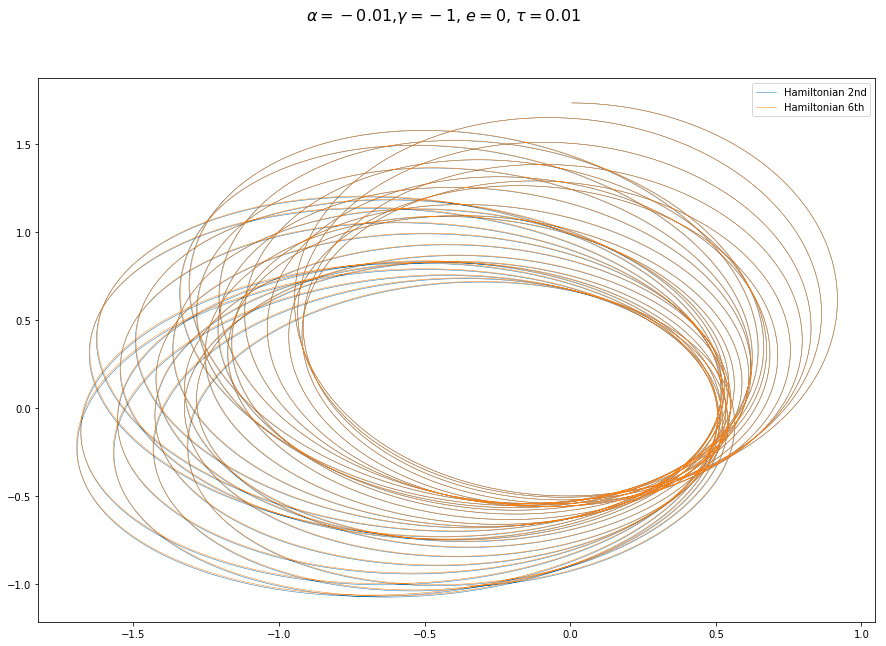

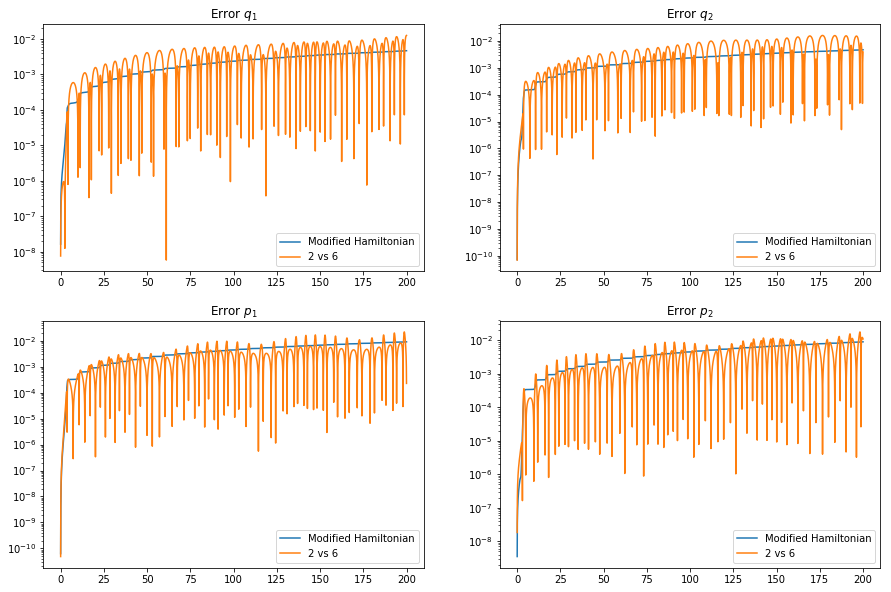

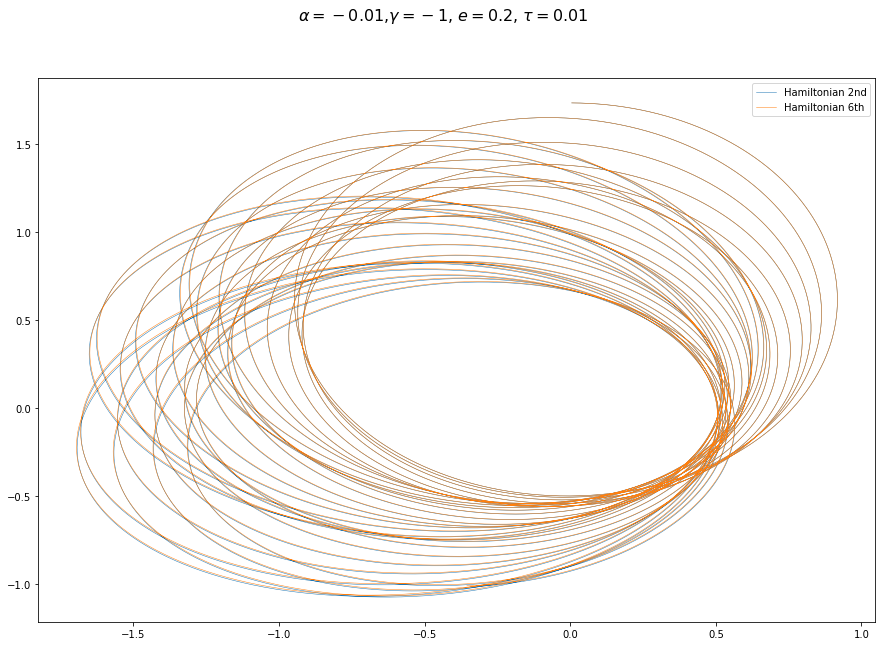

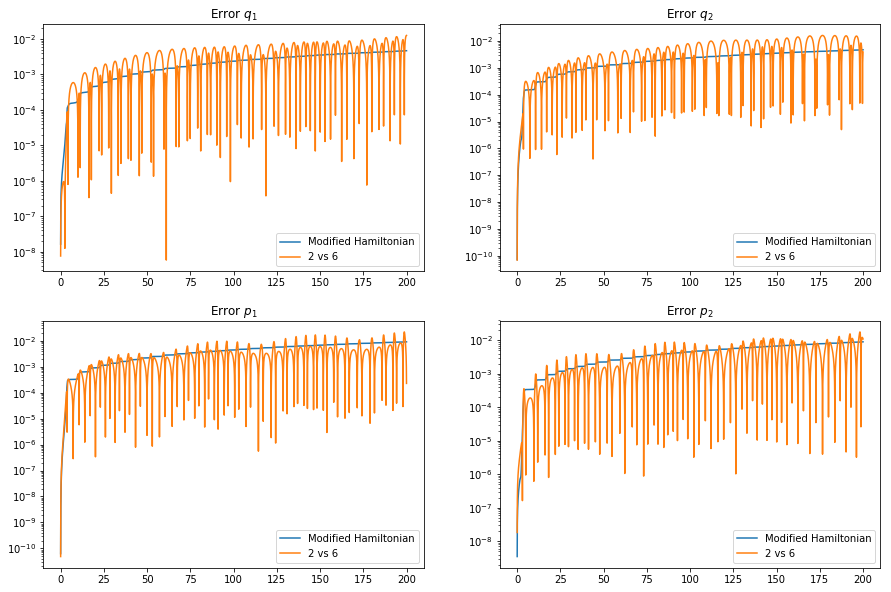

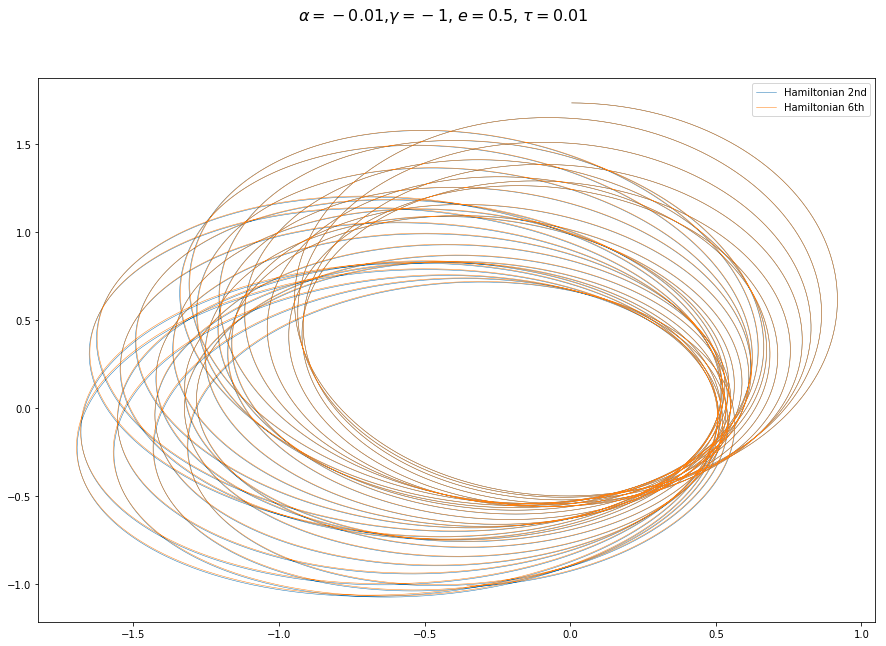

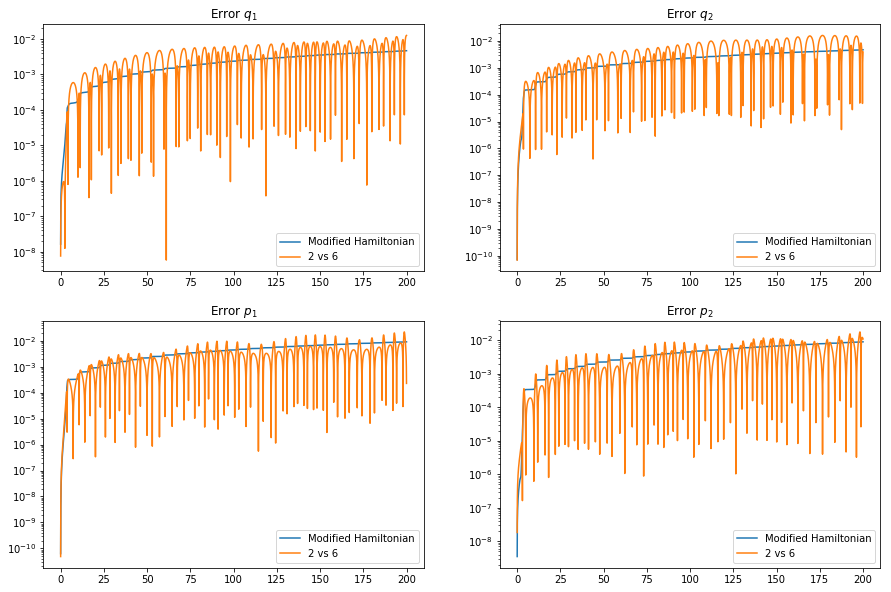

In [13]:
a=-0.01
tpk = TimePerturbedKepler(a, 1, -1)
dt = 0.01
tf = 200
i=0
tspan = np.arange(0.0, tf, dt)

errq1 = lambda t,q1,q2,p1,p2: upper_error_bound1(t,q1,q2,p1,p2,dt,a)
errq2 = lambda t,q1,q2,p1,p2: upper_error_bound2(t,q1,q2,p1,p2,dt,a)
errp1 = lambda t,q1,q2,p1,p2: upper_error_boundp1(t,q1,q2,p1,p2,dt,a)
errp2 = lambda t,q1,q2,p1,p2: upper_error_boundp2(t,q1,q2,p1,p2,dt,a)
plt.figure(figsize=(10,10))

err = np.empty([len(tspan), 4,4], dtype=np.float64)
for e in ([0,0.2,0.5]):
    plt.figure(figsize=(15,10))
    (p0, q0) = init_ecc(0.5)
    sol, sols, tspan = ic.integrate(ic.step, tpk, tspan, p0, q0, 0.0)
    solm, solms, _ = ic.integrate(ic.step6, tpk, tspan, p0, q0, 0.0)
    err[:,i,0]=abs((sol[:,1,0]-solm[:,1,0]))
    err[:,i,1]=abs((sol[:,1,1]-solm[:,1,1]))
    err[:,i,2]=abs((sol[:,0,0]-solm[:,0,0]))
    err[:,i,3]=abs((sol[:,0,1]-solm[:,0,1]))
    plt.suptitle(f"$\\alpha = {a}$,$\\gamma = -1$, $e = {e}$, $\\tau = {dt}$",size=16)
    plt.plot(sol[:,1,0],
             sol[:,1,1],
             linewidth=0.5, label="Hamiltonian 2nd")
    plt.plot(solm[:,1,0],
             solm[:,1,1],
             linewidth=0.5, label="Hamiltonian 6th")
    plt.legend()
    plt.show()
    plt.figure(figsize=(15,10))

    plt.subplot(221)
    plt.title("Error $q_1$")
    plt.plot(tspan,np.cumsum([errq1(t,q1,q2,p1,p2) for t,q1,q2,p1,p2 in zip(tspan,sol[:,1,0],sol[:,1,1],sol[:,0,0],sol[:,0,1])]),
         label="Modified Hamiltonian")
    plt.plot(tspan, err[:,i,0], label="2 vs 6")
    plt.yscale('log')    
    plt.legend()
    plt.subplot(222)
    plt.title("Error $q_2$")
    plt.plot(tspan,np.cumsum([errq2(t,q1,q2,p1,p2) for t,q1,q2,p1,p2 in zip(tspan,sol[:,1,0],sol[:,1,1],sol[:,0,0],sol[:,0,1])]),
         label="Modified Hamiltonian")
    plt.plot(tspan, err[:,i,1], label="2 vs 6")
    plt.yscale('log')
    plt.legend()
    plt.subplot(223)
    plt.title("Error $p_1$")
    plt.plot(tspan,np.cumsum([errp1(t,q1,q2,p1,p2) for t,q1,q2,p1,p2 in zip(tspan,sol[:,1,0],sol[:,1,1],sol[:,0,0],sol[:,0,1])]),
         label="Modified Hamiltonian")
    plt.plot(tspan, err[:,i,2], label="2 vs 6")
    plt.yscale('log')
    plt.legend()
    plt.subplot(224)
    plt.title("Error $p_2$")
    plt.plot(tspan,np.cumsum([errp2(t,q1,q2,p1,p2) for t,q1,q2,p1,p2 in zip(tspan,sol[:,1,0],sol[:,1,1],sol[:,0,0],sol[:,0,1])]),
         label="Modified Hamiltonian")
    plt.plot(tspan, err[:,i,3], label="2 vs 6")
    plt.yscale('log')
    plt.legend()
    plt.show()
    i+=1